In [1]:
from dask.optimization_ast import compile_ast
import pickle
import dask.array as da
import numpy as np

def da_compile_ast(a):
    dsk = compile_ast(a.__dask_graph__(), a.__dask_keys__())
    return da.Array(dsk, a.name, a.chunks, a.dtype, a.shape)

def define_std():
    a = da.arange(4, chunks=2)
    a = (a + 1) * (a - 1)
    a = ((a < 2) - 10) * ((a > 2) + 10)
    a = a + np.array([7, 8, 9, 10])
    a = a.sum()
    return a

def define_ast():
    a = da.arange(4, chunks=2)
    a = (a + 1) * (a - 1)
    # We're going to use this node as an input to
    # multiple ones; don't repeat calculations and
    # allow for parallelism. This is only a good idea if the
    # optimized calculation is expensive.
    a = da_compile_ast(a)

    a = ((a < 2) - 10) * ((a > 2) + 10)
    # An input that can't be decompiled into AST
    a = a + np.array([7, 8, 9, 10])
    # We're reaching a reduction - we can add an optimization
    # point here to increase parallelism. This is only a good
    # idea if the computation is not trivial.
    a = da_compile_ast(a)
    a = a.sum()
    # Final optimization
    a = da_compile_ast(a)
    return a

da_std = define_std()
da_ast = define_ast()
da_std.compute(), da_ast.compute()

(-366, -366)

In [2]:
pickle.loads(pickle.dumps(da_ast)).compute()

-366

In [3]:
print("Vanilla dask")
print("============")
print("definition")
%timeit define_std()
print("compute")
%timeit da_std.compute(optimize_graph=False)
%timeit da_std.compute(optimize_graph=True)
print("pickle->unpickle")
%timeit pickle.loads(pickle.dumps(da_std))
print()
print("AST optimized")
print("=============")
print("definition")
%timeit define_ast()
print("compute")
%timeit da_ast.compute(optimize_graph=False)
%timeit da_ast.compute(optimize_graph=True)
print("pickle->unpickle")
%timeit pickle.loads(pickle.dumps(da_ast))

Vanilla dask
definition
2.31 ms ± 78.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
compute
2.32 ms ± 83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.77 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
pickle->unpickle
72.2 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

AST optimized
definition
4.78 ms ± 79.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
compute
725 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
835 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pickle->unpickle
87.9 µs ± 586 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [4]:
for k, v in da_ast.dask.items():
    print(k)
    print(v)
    print("-----------------------")
    print(v[0].source)
    print("=======================")    

('add-5276b14ff4d606ab6a1d07926d073b9c', 0)
(<ASTFunction -4645297178831571099>, array([ 7,  8,  9, 10]), ('mul-31965abd6d7d3ec32210151a917a7489', 0))
-----------------------
import numpy


def _ast_compiled(ndarray_0, dsk_mul_1):
    dsk_lt_0 = dsk_mul_1 < 2
    dsk_sub_0 = dsk_lt_0 - 10
    dsk_gt_0 = dsk_mul_1 > 2
    dsk_add_1 = dsk_gt_0 + 10
    dsk_mul_0 = dsk_sub_0 * dsk_add_1
    str_0 = ndarray_0
    dsk_array_0 = numpy.asarray(str_0[slice(0, 4, None),])
    dsk_rechunk_1 = dsk_array_0[slice(0, 2, None),]
    dsk_rechunk_0 = dsk_rechunk_1
    dsk_add_0 = dsk_mul_0 + dsk_rechunk_0
    return dsk_add_0

('add-5276b14ff4d606ab6a1d07926d073b9c', 1)
(<ASTFunction 3732589384392712993>, array([ 7,  8,  9, 10]), ('mul-31965abd6d7d3ec32210151a917a7489', 1))
-----------------------
import numpy


def _ast_compiled(ndarray_0, dsk_mul_1):
    dsk_lt_0 = dsk_mul_1 < 2
    dsk_sub_0 = dsk_lt_0 - 10
    dsk_gt_0 = dsk_mul_1 > 2
    dsk_add_1 = dsk_gt_0 + 10
    dsk_mul_0 = dsk_sub_0 * dsk_ad

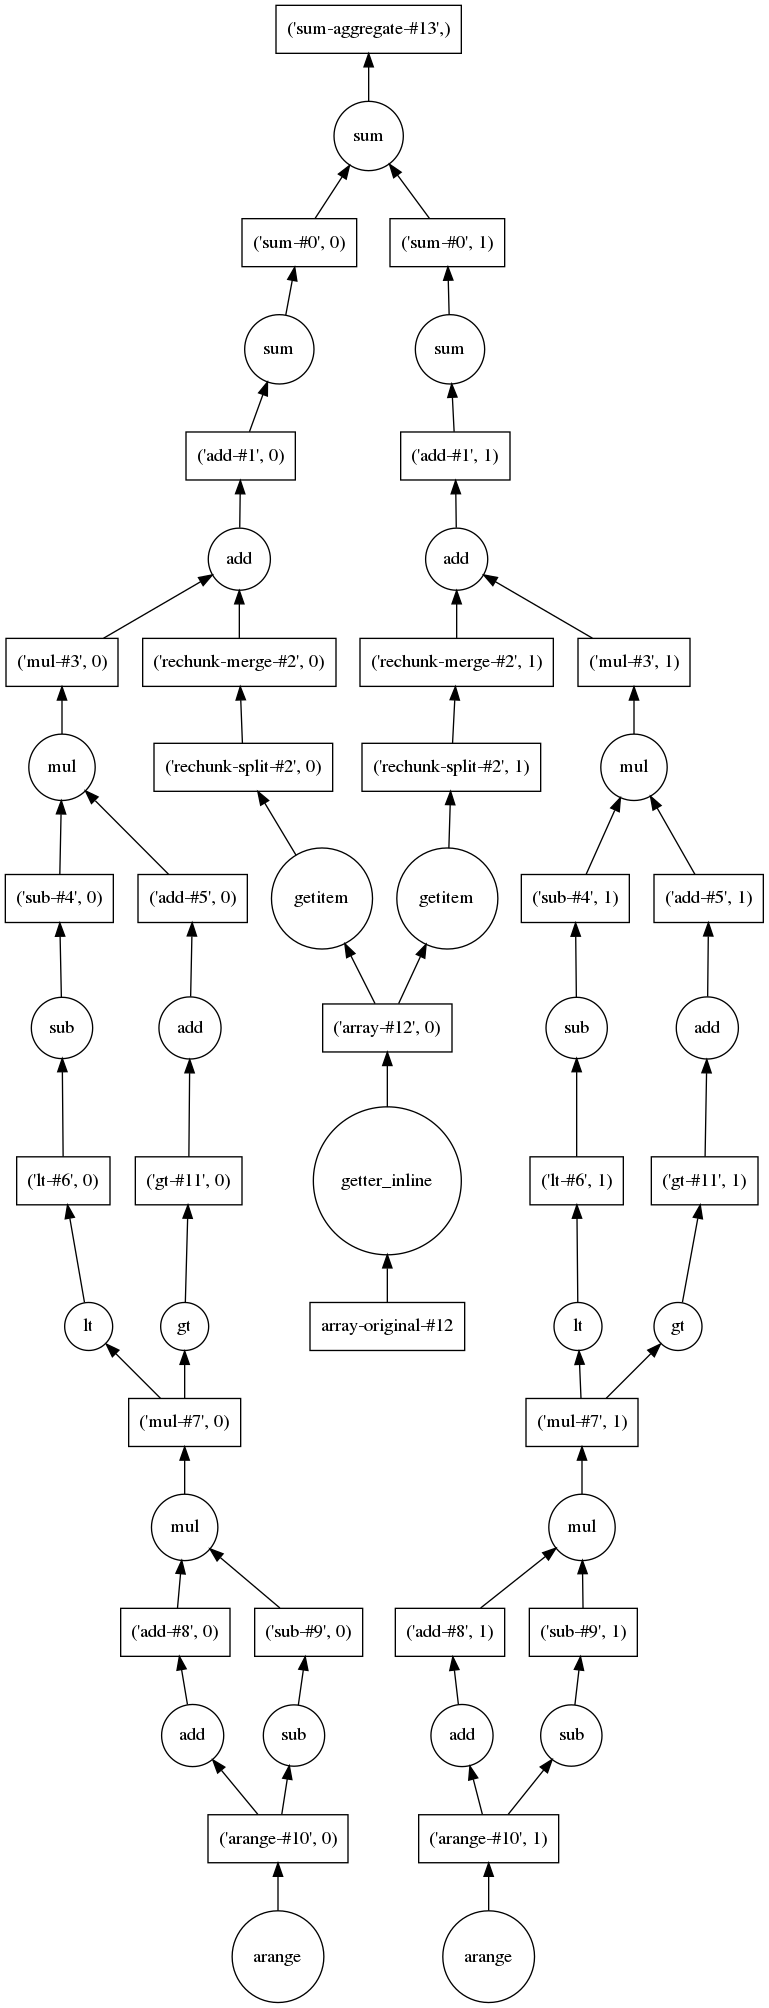

In [5]:
da_std.visualize()

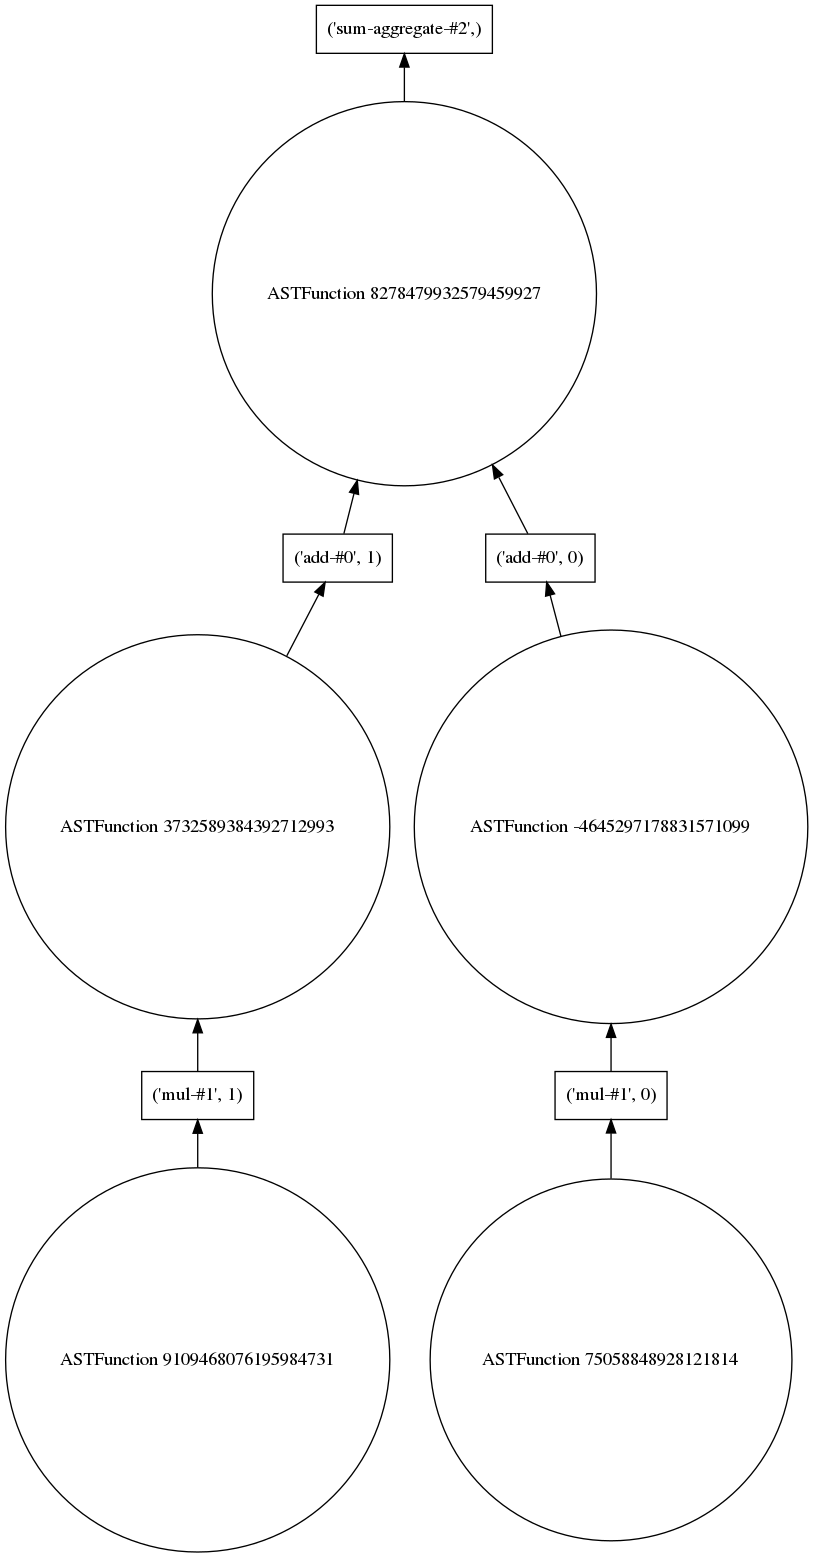

In [6]:
da_ast.visualize()